In [2]:
import os
import joblib
from pathlib import Path
from matplotlib import colormaps
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import random
import typer
from skimage import exposure

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, label_binarize
from sklearn.decomposition import PCA

from skimage.feature import hog

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [3]:
PROJ_ROOT = Path().resolve().parents[0]

DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
EXTERNAL_DATA_DIR = DATA_DIR / "external"

MODELS_DIR = PROJ_ROOT / "models/tmp"

### FEATURES AND DATA PROCESSING

In [4]:
def load_data(file_path, encoding=None):
    with open(file_path, 'rb') as f:
        if (encoding is not None):
            data = pickle.load(f, encoding=encoding)
        else:
            data = pickle.load(f)
    return data

def save_data(data, file):
    with open(file, 'wb') as f:
        pickle.dump(data, f)

def to_image(img_flat):
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    return img

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def extract_hog_features(images):
    hog_features = []

    for image in images:
        gray_image = rgb2gray(image)
        feature, hog_image = hog(
            gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
            visualize=True, channel_axis=-1
        )
        hog_features.append(feature)
    
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image')
    ax2.imshow(hog_image_rescaled, cmap='gray')
    # ax2.imshow(hog_image, cmap='gray') # -> without exposure rescale intensity
    ax2.axis('off')
    ax2.set_title('HOG Image')
    plt.show()

    return np.array(hog_features)

### METHODS FOR MODELS LOADING & SAVING

In [5]:
def save_model(model, model_name, model_dir='models'):
    """
    Save the trained model to a file.
    
    Args:
        model: Trained model to be saved.
        model_name: The name of the model file.
        model_dir: Directory where the model will be saved.
    """
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    file_path = os.path.join(model_dir, model_name)
    joblib.dump(model, file_path)
    print(f"Model saved to {file_path}")

def load_model(model_name, model_dir='models'):
    """
    Load a trained model from a file.
    
    Args:
        model_name: The name of the model file.
        model_dir: Directory where the model is saved.
    
    Returns:
        Loaded model.
    """
    file_path = os.path.join(model_dir, model_name)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No model found at {file_path}")
    
    model = joblib.load(file_path)
    print(f"Model loaded from {file_path}")
    return model

### PATHS

In [6]:
input_path: Path = RAW_DATA_DIR / "cifar-10-batches-py"
data_path: Path = EXTERNAL_DATA_DIR / "processed_dataset.pkl"
predictions_path: Path = EXTERNAL_DATA_DIR / "test_predictions.csv"
model_path: Path = MODELS_DIR

### DATASET

In [6]:
print("Processing dataset...")
meta_dict = load_data(input_path / "batches.meta", encoding='bytes')
label_names = meta_dict[b'label_names']
print(f"Labels/Features: {label_names}")

combined_dict = {
    b'data': [],
    b'labels': [],
    b'label_names': label_names,
    b'hog_data': [],
    b'validation_data': [],
    b'validation_labels': [],
    b'validation_hog_data': [],
    b'test_data': [],
    b'test_labels': [],
    b'test_hog_data': [],
    b'sample_images': {label: [] for label in label_names}
}

for i in range(5):
    batch_dict = load_data(input_path / f"data_batch_{i+1}", encoding='bytes')
    combined_dict[b'data'].extend(batch_dict[b'data'])
    combined_dict[b'labels'].extend(batch_dict[b'labels'])

# Diviser les données en données d'entraînement et de validation
combined_dict[b'data'], combined_dict[b'validation_data'], combined_dict[b'labels'], combined_dict[b'validation_labels'] = train_test_split(
    combined_dict[b'data'], combined_dict[b'labels'], test_size=0.2, random_state=42
)

# Charger les données de test depuis test_batch
test_batch_dict = load_data(input_path / "test_batch", encoding='bytes')
combined_dict[b'test_data'].extend(test_batch_dict[b'data'])
combined_dict[b'test_labels'].extend(test_batch_dict[b'labels'])

# Sélectionner 10 images aléatoires pour chaque classe
for label_index, label in enumerate(label_names):
    label_indices = [i for i, lbl in enumerate(combined_dict[b'labels']) if lbl == label_index]
    sample_indices = random.sample(label_indices, 10)
    for idx in sample_indices:
        combined_dict[b'sample_images'][label].append(combined_dict[b'data'][idx])

with open(data_path, 'wb') as f:
    pickle.dump(combined_dict, f)

Processing dataset...
Labels/Features: [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


### DATA DICTIONARY KEYS

In [7]:
combined_dict.keys()

dict_keys([b'data', b'labels', b'label_names', b'hog_data', b'validation_data', b'validation_labels', b'validation_hog_data', b'test_data', b'test_labels', b'test_hog_data', b'sample_images'])

### MODELS

In [8]:
models = {
    'random_forest': RandomForestClassifier(random_state=42, criterion='entropy', max_depth=10), # criterion, max_depth
    'svm': SVC(max_iter=100 , kernel='rbf', random_state=42), # degree, gamma
    'logistic_regression': LogisticRegression(random_state=42), # penalty, solver
    'knn': KNeighborsClassifier(), # n_neighbors, algorithm
    # 'gradient_boosting': GradientBoostingClassifier(learning_rate=0.01, random_state=42) # loss, max_depth, criterion
}

### PIPELINE

In [9]:
pipeline = Pipeline([
    # ('greyscale', FunctionTransformer(rgb2gray, validate=False)),
    ('hog_extraction', FunctionTransformer(extract_hog_features, validate=False)),
    # ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=100)),  # Réduction de dimensionnalité avec PCA
    ('classifier', None)
])

### TRAINING & EVALUATING

In [ ]:
data = load_data(data_path)

X_train = np.array(data[b'data']).reshape(-1, 32, 32, 3) / 255.0
y_train = np.array(data[b'labels'])
X_train = X_train.reshape(X_train.shape[0], -1)
X_train = np.array([to_image(img) for img in X_train])

train_dict = {
    b'data': X_train,
    b'labels': y_train,
}
save_data(train_dict, EXTERNAL_DATA_DIR / "train_data.pkl")

print(X_train.shape, y_train.shape)

X_validation = np.array(data[b'validation_data']).reshape(-1, 32, 32, 3) / 255.0
y_validation = np.array(data[b'validation_labels'])
X_validation = X_validation.reshape(X_validation.shape[0], -1)
X_validation = np.array([to_image(img) for img in X_validation])

validation_dict = {
    b'data': X_validation,
    b'labels': y_validation,
}
save_data(validation_dict, EXTERNAL_DATA_DIR / "validation_data.pkl")

print(X_validation.shape, y_validation.shape)

# Train the models
for name, model in models.items():
    print(f"Training {name} model...")
    pipeline.set_params(classifier=model)
    pipeline.fit(X_train, y_train)
    print(f"{name} model trained.")
    y_pred = pipeline.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    print(f"{name} model accuracy: {accuracy:.2f}")
    save_model(model, f"{name}_model.pkl", model_path)
    print(f"{name} model saved.")

KeyboardInterrupt: 

### TESTING

In [ ]:
X_test = np.array(data[b'test_data']).reshape(-1, 32, 32, 3) / 255.0
y_test = np.array(data[b'test_labels'])
X_test = X_test.reshape(X_test.shape[0], -1)
X_test = [to_image(im) for im in X_test]
X_test = extract_hog_features(X_test)

test_dict = {
    b'data': X_test,
    b'labels': y_test,
}
save_data(test_dict, EXTERNAL_DATA_DIR / "test_data.pkl")

predictions = {'True Labels': y_test}

# Evaluate the models
for name, _ in models.items():
    model = load_model(f'{name}_model.pkl', model_path)
    print(f"Evaluating {name} model...")
    predictions[name] = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions[name])
    print(f"{name} model accuracy: {accuracy:.2f}")
    scores = cross_val_score(model, X_test, y_test, cv=5)
    print(f"{name} model cross-validation accuracy: {scores.mean():.2f}")

predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(predictions_path, index=False)
print(f"Predictions saved to {predictions_path}")

Model loaded from /mnt/d/Epita/MLRF/cifar_mlrf/models/tmp/random_forest_model.pkl
Evaluating random_forest model...
random_forest model accuracy: 0.48
random_forest model cross-validation accuracy: 0.46
Model loaded from /mnt/d/Epita/MLRF/cifar_mlrf/models/tmp/svm_model.pkl
Evaluating svm model...
svm model accuracy: 0.40


/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solv

svm model cross-validation accuracy: 0.47
Model loaded from /mnt/d/Epita/MLRF/cifar_mlrf/models/tmp/logistic_regression_model.pkl
Evaluating logistic_regression model...
logistic_regression model accuracy: 0.53


/home/nicolas/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nicolas/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

logistic_regression model cross-validation accuracy: 0.51
Model loaded from /mnt/d/Epita/MLRF/cifar_mlrf/models/tmp/knn_model.pkl
Evaluating knn model...
knn model accuracy: 0.51
knn model cross-validation accuracy: 0.44
Predictions saved to /mnt/d/Epita/MLRF/cifar_mlrf/data/external/test_predictions.csv


### GRAPH PLOTS

Plotting evaluation metrics...


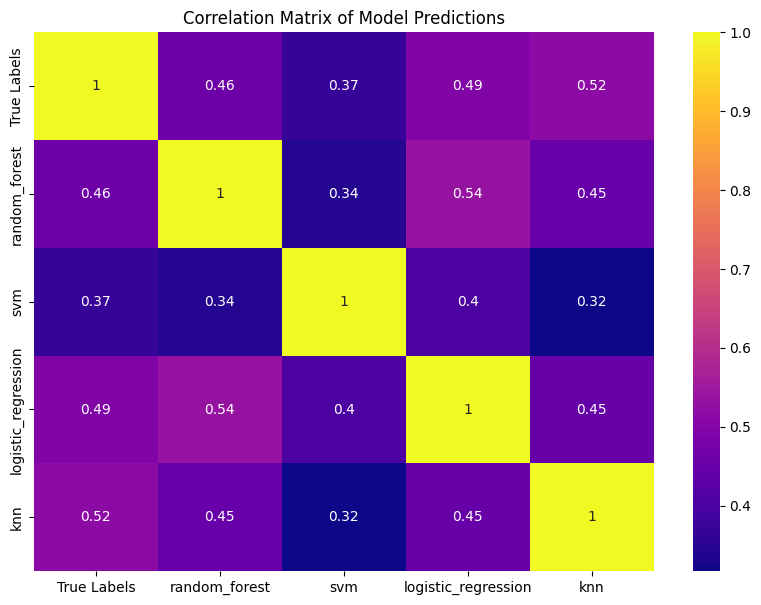

Plotting evaluation metrics for random_forest...


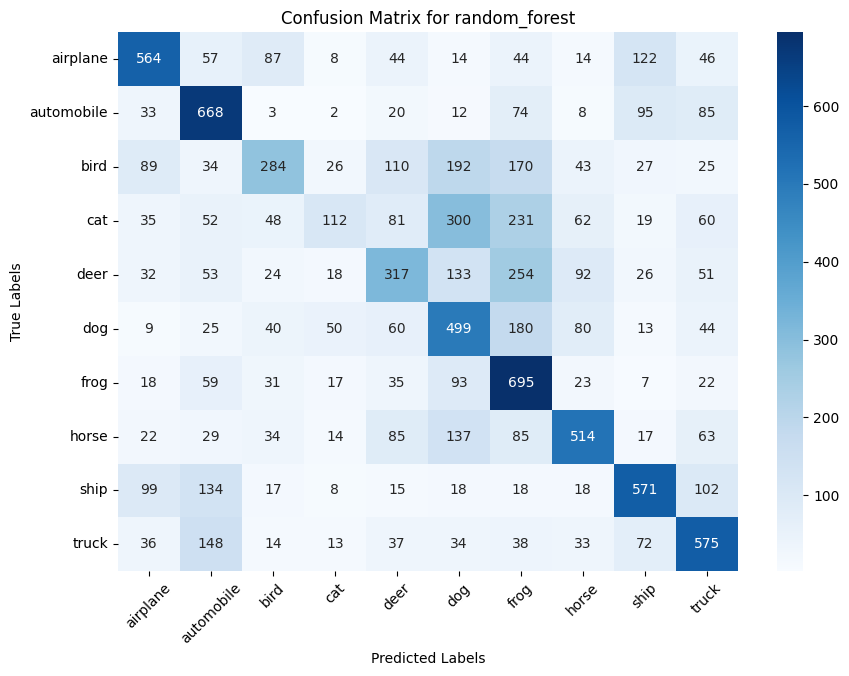

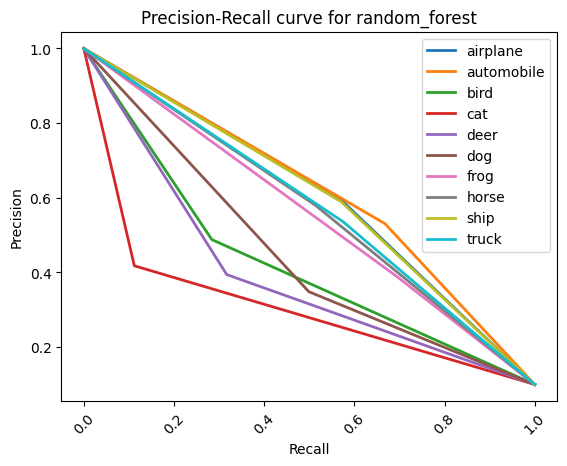

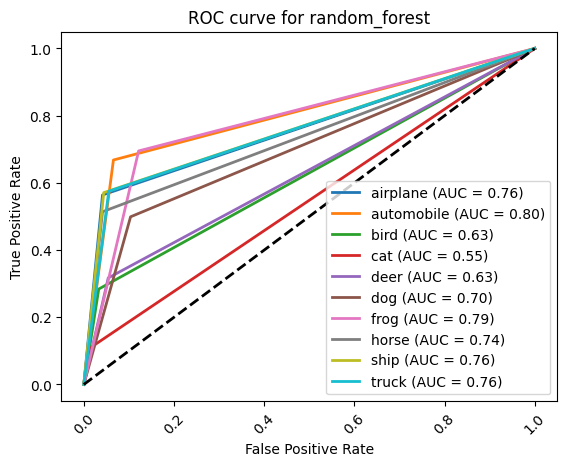

Plotting evaluation metrics for svm...


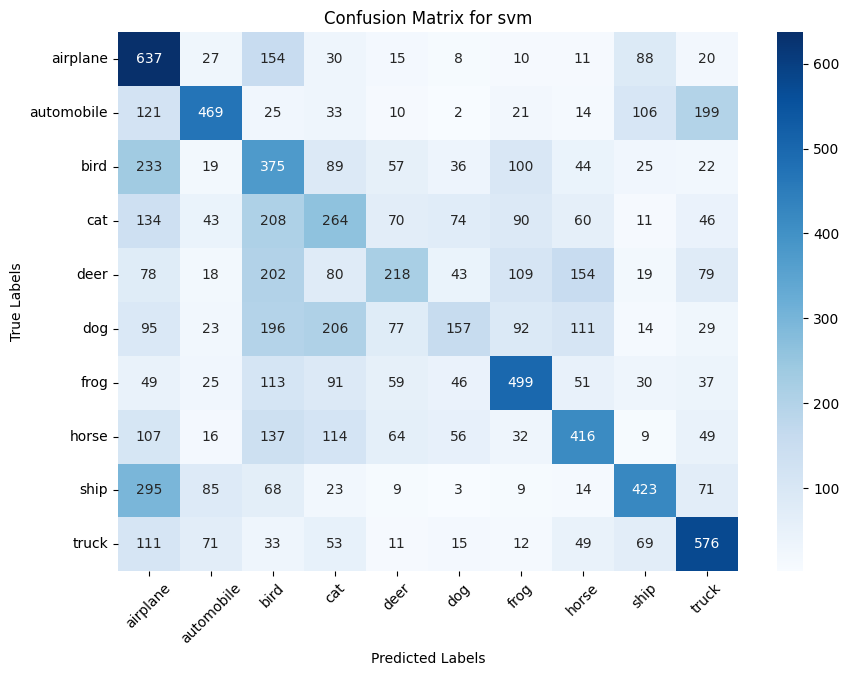

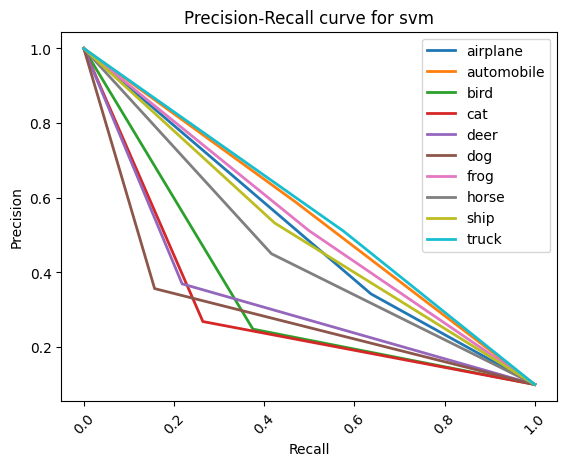

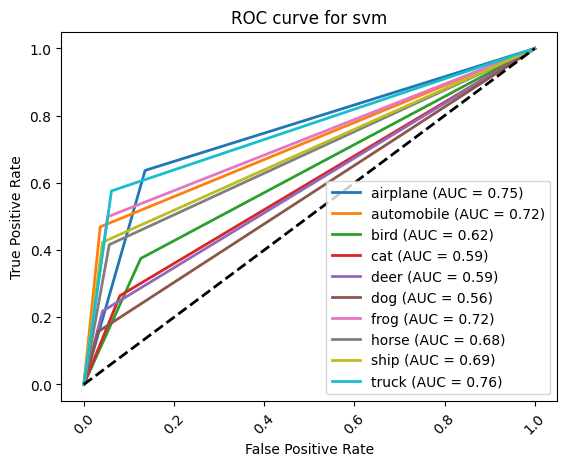

Plotting evaluation metrics for logistic_regression...


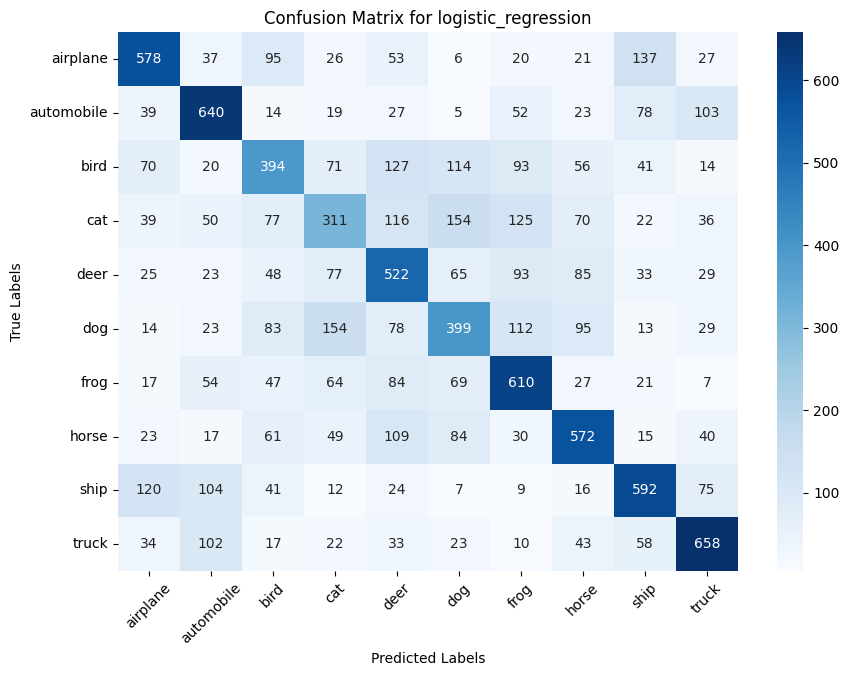

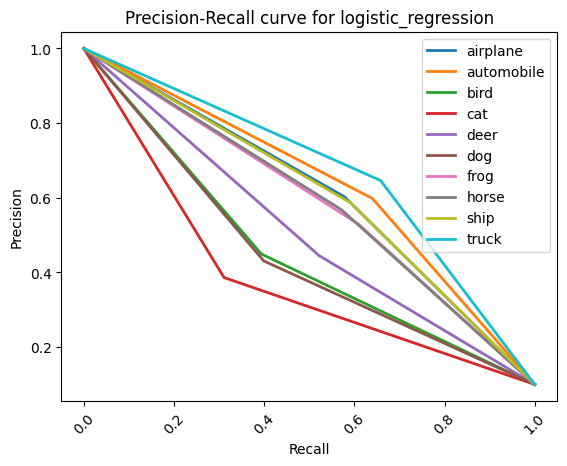

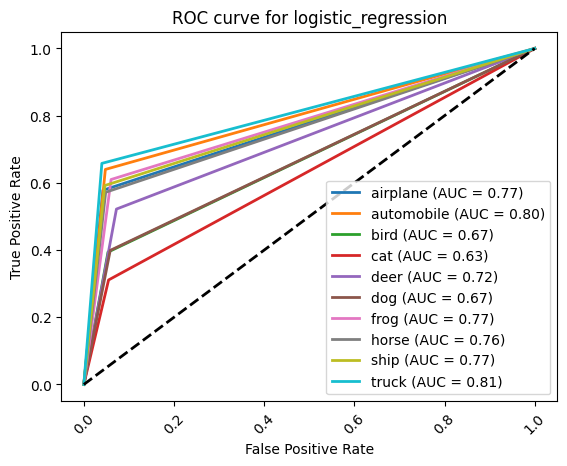

Plotting evaluation metrics for knn...


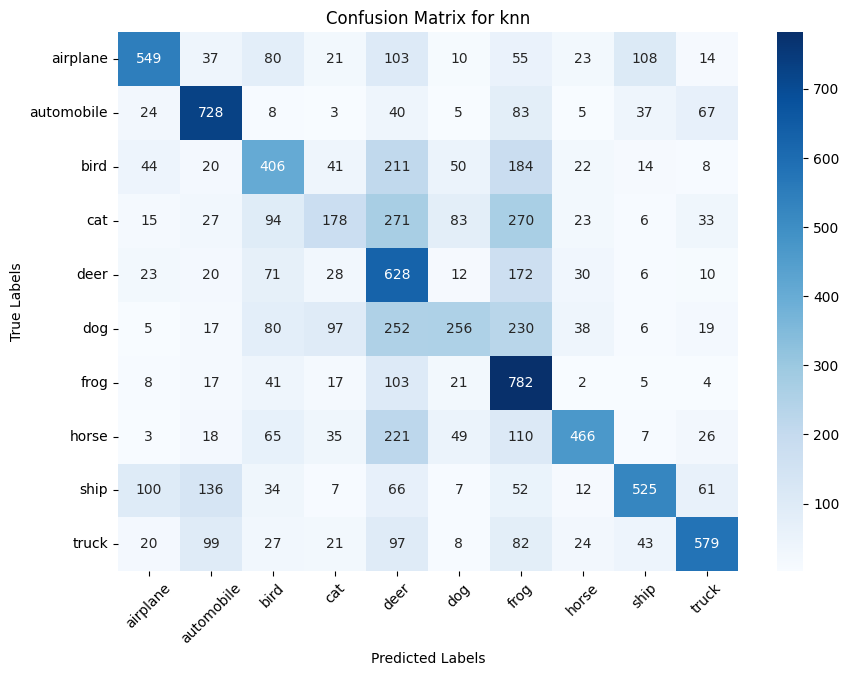

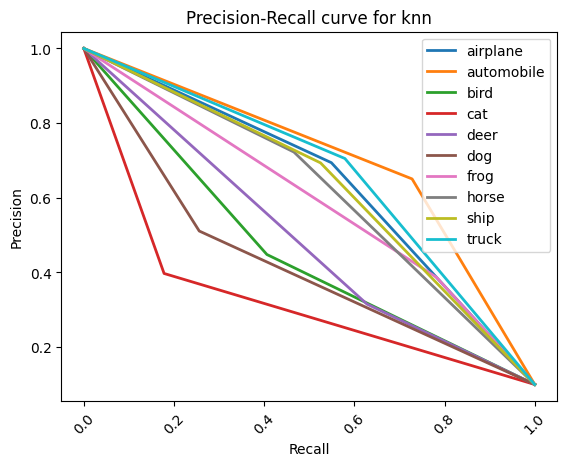

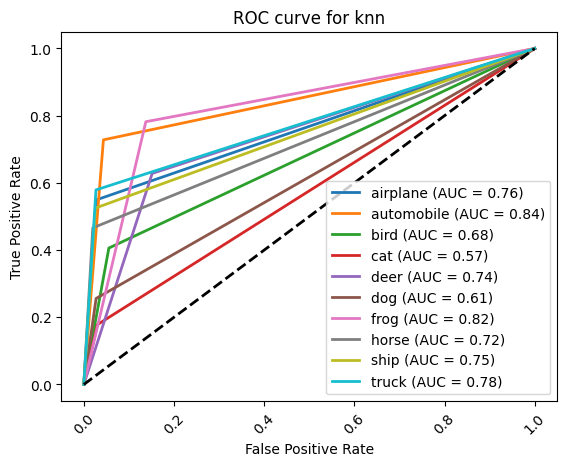

In [9]:
predictions_df = pd.read_csv(predictions_path)
data = load_data(data_path)
label_names = [label.decode('utf-8') for label in data[b'label_names']]

train_data = load_data(EXTERNAL_DATA_DIR / "train_data.pkl")
test_data = load_data(EXTERNAL_DATA_DIR / "test_data.pkl")

X_train = np.array(train_data[b'data'])
y_train = np.array(train_data[b'labels'])
X_test = np.array(test_data[b'data'])
y_test = np.array(test_data[b'labels'])

print(f"Plotting evaluation metrics...")

# Correlation des prédictions
correlation_matrix = predictions_df.corr()
plt.figure(figsize=(10, 7))
plt.title('Correlation Matrix of Model Predictions')
sns.heatmap(correlation_matrix, annot=True, cmap='plasma')
plt.show()

n_classes = len(label_names)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Matrice de confusion
for name, _ in models.items():
    print("=============================================================")
    print(f"Plotting evaluation metrics for {name}...")
    predictions = predictions_df[name]
    cmat = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(10, 7))
    plt.title(f'Confusion Matrix for {name}')
    plt.xticks(rotation=45)
    sns.heatmap(cmat, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Courbes de précision/rappel et ROC
    preds_bin = label_binarize(predictions, classes=np.arange(n_classes))
    
    # Precision-Recall curve
    plt.figure()
    for i, label in enumerate(label_names):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], preds_bin[:, i])
        plt.plot(recall, precision, lw=2, label=f'{label}')
    plt.xticks(rotation=45)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for {name}')
    plt.legend(loc='best')
    plt.show()
    
    # ROC curve
    plt.figure()
    for i, label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], preds_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xticks(rotation=45)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {name}')
    plt.legend(loc='best')
    plt.show()

### PLOT CLASSIFIER COMPARISON

ValueError: 'c' argument has 40000 elements, which is inconsistent with 'x' and 'y' with size 3840000.

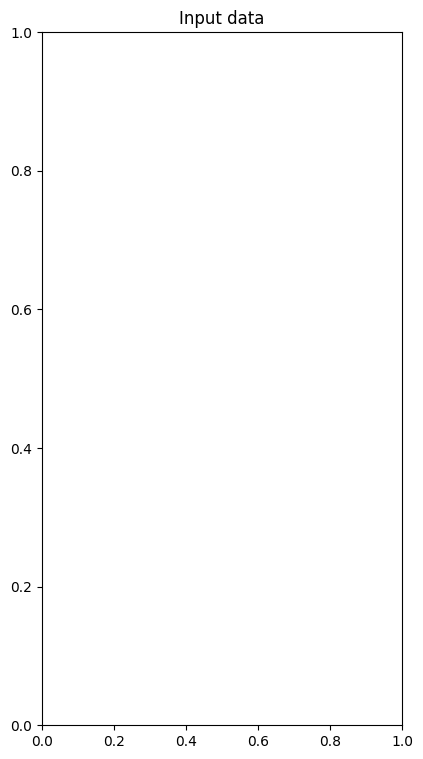

In [10]:
figure = plt.figure(figsize=(27, 9))
i = 1

x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5

cm = colormaps.get_cmap('tab10')
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(models) + 1, i)
ax.set_title('Input data')
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

for name, _ in models.items():
    model = joblib.load(model_path / f'{name}_model.pkl')
    score = model.score(X_test, y_test)

    ax = plt.subplot(1, len(models) + 1, i)

    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f'{name} (score = {score:.2f})')
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.show()

In [11]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# Appliquer la transformation HOG sur les images
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Réduire la dimensionnalité des données à 2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_hog)
X_test_2d = pca.transform(X_test_hog)

# Tracer les données en 2D
figure = plt.figure(figsize=(27, 9))
i = 1

x_min, x_max = X_train_2d[:, 0].min() - 0.5, X_train_2d[:, 0].max() + 0.5
y_min, y_max = X_train_2d[:, 1].min() - 0.5, X_train_2d[:, 1].max() + 0.5

cm = cm.get_cmap('tab10')
ax = plt.subplot(1, len(models) + 1, i)
ax.set_title('Input data')
scatter = ax.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=cm, edgecolors='k')
ax.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=cm, edgecolors='k', alpha=0.6)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

for name, _ in models.items():
    model = joblib.load(MODELS_DIR / f'{name}_model.pkl')
    score = model.score(X_test_hog, y_test)

    ax = plt.subplot(1, len(models) + 1, i)

    ax.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=cm, edgecolors='k')
    ax.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=cm, edgecolors='k', alpha=0.6)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f'{name} (score = {score:.2f})')
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.colorbar(scatter, ax=figure.axes)
plt.show()

ValueError: Only images with two spatial dimensions are supported. If using with color/multichannel images, specify `channel_axis`.